In [1]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import cv2
from scipy.ndimage import affine_transform
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation


In [2]:
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LucasKanade import LucasKanade
from matplotlib import animation
from tqdm import tqdm



In [52]:
seq = np.load("../data/carseq.npy")  #Load teting video seq

##### Run LK Tracking
rect = np.array([59, 116, 145, 151]).T

lk_res = []
lk_res.append(rect)
# for i in tqdm(range(1, seq.shape[2])):
i = 2
pt_topleft = rect[:2]
pt_bottomright = rect[2:4]
It = seq[:,:,i-1]
It1 = seq[:,:,i]
#     p = LucasKanade(It, It1, rect, threshold, num_iters)
p = LucasKanade(It, It1, rect)
rect = np.concatenate((pt_topleft + p, pt_bottomright + p))
lk_res.append(rect)

lk_res = np.array(lk_res)
np.save("carseqrects.npy", lk_res)

In [53]:
lk_res

array([[ 59.        , 116.        , 145.        , 151.        ],
       [ 58.50395201, 116.93509982, 144.50395201, 151.93509982]])

In [31]:
seq = np.load("../data/carseq.npy")  #Load teting video seq
rect = np.array([59, 116, 145, 151]).T
i = 1
It = seq[:,:,i-1]
It1 = seq[:,:,i]

# It = seq[:,:,100]
# It1 = seq[:,:,1]

In [180]:
rect

array([ 59, 116, 145, 151])

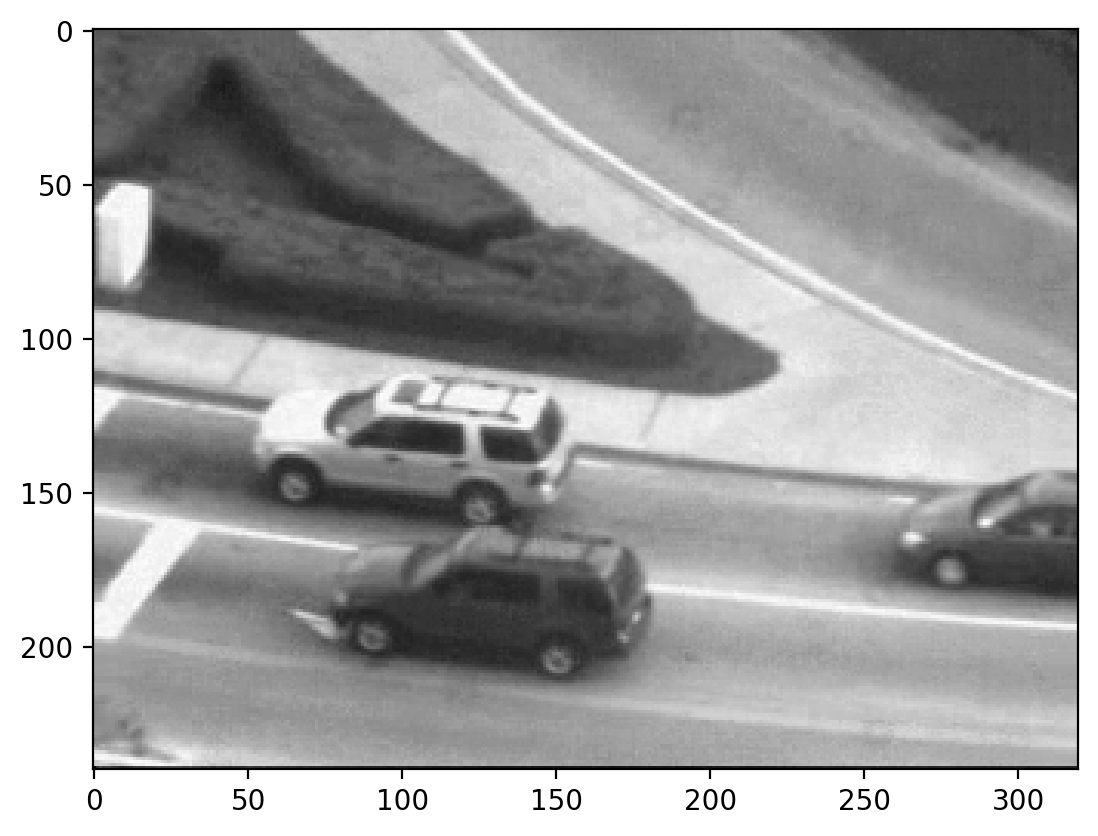

In [165]:
# plt.imshow(It, cmap='gray')
# plt.show()
plt.imshow(It1, cmap='gray')
plt.show()

In [68]:
seq = np.load("../data/carseq.npy")  #Load teting video seq

##### Run LK Tracking
rect = np.array([59, 116, 145, 151]).T

lk_res = []
lk_res.append(rect)
for i in tqdm(range(1, seq.shape[2])):
    pt_topleft = rect[:2]
    pt_bottomright = rect[2:4]
    It = seq[:,:,i-1]
    It1 = seq[:,:,i]
#     p = LucasKanade(It, It1, rect, threshold, num_iters)
    p = LucasKanade(It, It1, rect)
    rect = np.concatenate((pt_topleft + p, pt_bottomright + p))
    lk_res.append(rect)

lk_res = np.array(lk_res)
np.save("carseqrects.npy", lk_res)


100%|█████████████████████████████████████████| 414/414 [00:07<00:00, 53.14it/s]


In [181]:
It.shape

(240, 320)

In [182]:
x1, y1, x2, y2 = rect[0], rect[1], rect[2], rect[3] #image coordinates, not matrix
rows_img, cols_img = It.shape
# rows_rect, cols_rect = x2 - x1, y2 - y1
rows_rect, cols_rect = y2 - y1, x2 - x1 

dp = [[cols_img], [rows_img]] #just an intial value to enforce the loop

# template-related can be precomputed
Iy, Ix = np.gradient(It1)
# x = np.arange(0, rows_img, 1)
# y = np.arange(0, cols_img, 1)   
x = np.arange(0, cols_img, 1)
y = np.arange(0, rows_img, 1)   

# y = np.arange(0, rows_img, 1)
# x = np.arange(0, cols_img, 1)     
#     c = np.linspace(x1, x2, cols_rect)
#     r = np.linspace(y1, y2, rows_rect)
# c = np.linspace(x1, x2, int(cols_rect))
# r = np.linspace(y1, y2, int(rows_rect))
c = np.linspace(x1, x2, int(cols_rect))
r = np.linspace(y1, y2, int(rows_rect))
# cc, rr = np.meshgrid(c, r)
cc, rr = np.meshgrid(c, r)
spline = RectBivariateSpline(y, x, It) #Spline interpolation over a rectangular mesh
T = spline.ev(rr, cc)
# spline = RectBivariateSpline(y, x, It)
# T = spline.ev(rr, cc)
spline_gx = RectBivariateSpline(y, x, Ix)
spline_gy = RectBivariateSpline(y, x, Iy)
spline1 = RectBivariateSpline(y, x, It1)


# in translation model jacobian is not related to coordinates
p0=np.zeros(2)

jac = np.array([[1,0],[0,1]])

p = p0

counter = 1
while np.square(dp).sum() > threshold and counter <= num_iters:

    # warp image using translation motion model
    x1_w, y1_w, x2_w, y2_w = x1+p[0], y1+p[1], x2+p[0], y2+p[1]

    #         cw = np.linspace(x1_w, x2_w, cols_rect)
    #         rw = np.linspace(y1_w, y2_w, rows_rect)
    cw = np.linspace(x1_w, x2_w, int(cols_rect))
    rw = np.linspace(y1_w, y2_w, int(rows_rect))
    ccw, rrw = np.meshgrid(cw, rw)

    warpImg = spline1.ev(rrw, ccw)

    #compute error image
    err = T - warpImg
    errImg = err.reshape(-1,1) #Columnize

    #compute gradient
    Ix_w = spline_gx.ev(rrw, ccw)
    Iy_w = spline_gy.ev(rrw, ccw)
    #I is (n,2)
    I = np.vstack((Ix_w.ravel(),Iy_w.ravel())).T

    #computer Hessian
    delta = I @ jac 
    #H is (2,2)
    H = delta.T @ delta

    #compute dp
    #dp is (2,2)@(2,n)@(n,1) = (2,1)
    dp = np.linalg.inv(H) @ (delta.T) @ errImg

    #update parameters
    p[0] += dp[0,0]
    p[1] += dp[1,0]
    
    counter += 1



In [215]:
def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param It: template image
    :param It1: Current image
    :param rect: Current position of the car (top left, bot right coordinates) -> template
    :param threshold: if the length of dp is smaller than the threshold, terminate the optimization
    :param num_iters: number of iterations of the optimization
    :param p0: Initial movement vector [dp_x0, dp_y0]
    :return: p: movement vector [dp_x, dp_y]
    """
	
    # Put your implementation here
    # set up the threshold
    ################### TODO Implement Lucas Kanade ###################
    H_It, W_It = It.shape
    
    x1, y1, x2, y2 = rect[0], rect[1], rect[2], rect[3] #writen in image coordinates, not matrix
    H_rect, W_rect = y2 - y1, x2 - x1 

    It1_y, It1_x = np.gradient(It1) #Gradient of current img

    x_axis_rect = np.linspace(x1, x2, int(W_rect))
    y_axis_rect = np.linspace(y1, y2, int(H_rect))
    X_grid_rect, Y_grid_rect = np.meshgrid(x_axis_rect, y_axis_rect)
    
    x = np.arange(0, W_It, 1)
    y = np.arange(0, H_It, 1)   
    spline_It = RectBivariateSpline(y, x, It) #Spline interpolation over a rectangular mesh
    spline_It1 = RectBivariateSpline(y, x, It1)
    spline_It1_x = RectBivariateSpline(y, x, It1_x)
    spline_It1_y = RectBivariateSpline(y, x, It1_y)
    template_rect = spline_It.ev(Y_grid_rect, X_grid_rect) #Bring template_rect from It

    # Iterations for finding optimal dp
    p = p0
    dp = [[1000], [1000]] #Big dp for while loop
    counter = 1
    while np.square(dp).sum() > threshold and counter <= num_iters:

        # translate the rectangle
        x1_tr, y1_tr, x2_tr, y2_tr = x1+p[0], y1+p[1], x2+p[0], y2+p[1]

        x_axis_rect_tr = np.linspace(x1_tr, x2_tr, int(W_rect))
        y_axis_rect_tr = np.linspace(y1_tr, y2_tr, int(H_rect))
        X_grid_rect_tr, Y_grid_rect_tr = np.meshgrid(x_axis_rect_tr, y_axis_rect_tr)

        spline_It1_tr = spline_It1.ev(Y_grid_rect_tr, X_grid_rect_tr)

        #A, b
        It1_rect_tr_x = spline_It1_x.ev(Y_grid_rect_tr, X_grid_rect_tr)
        It1_rect_tr_y = spline_It1_y.ev(Y_grid_rect_tr, X_grid_rect_tr)
        A = np.vstack((It1_rect_tr_x.ravel(),It1_rect_tr_y.ravel())).T

        b = (template_rect - spline_It1_tr).reshape(-1, 1)
        b = b.reshape(-1,1) #Columnize

        #Solve argmin|Ax-b|^2 for finding dp
        dp = np.linalg.inv(A.T@A) @ (A.T) @ b

        #update parameters
        p[0] += dp[0,0]
        p[1] += dp[1,0]

        counter += 1
        
    return p

In [214]:
num_iters = 1e4
threshold = 1e-2

seq = np.load("../data/carseq.npy")  #Load teting video seq

##### Run LK Tracking
rect = np.array([59, 116, 145, 151]).T

lk_res = []
lk_res.append(rect)
for i in tqdm(range(1, seq.shape[2])):
    pt_topleft = rect[:2]
    pt_bottomright = rect[2:4]
    It = seq[:,:,i-1]
    It1 = seq[:,:,i]
    p = LucasKanade_mine(It, It1, rect, threshold, num_iters)
#     p = LucasKanade_mine(It, It1, rect)
    rect = np.concatenate((pt_topleft + p, pt_bottomright + p))
    lk_res.append(rect)

lk_res = np.array(lk_res)
np.save("carseqrects_test.npy", lk_res)


100%|█████████████████████████████████████████| 414/414 [00:08<00:00, 50.08it/s]


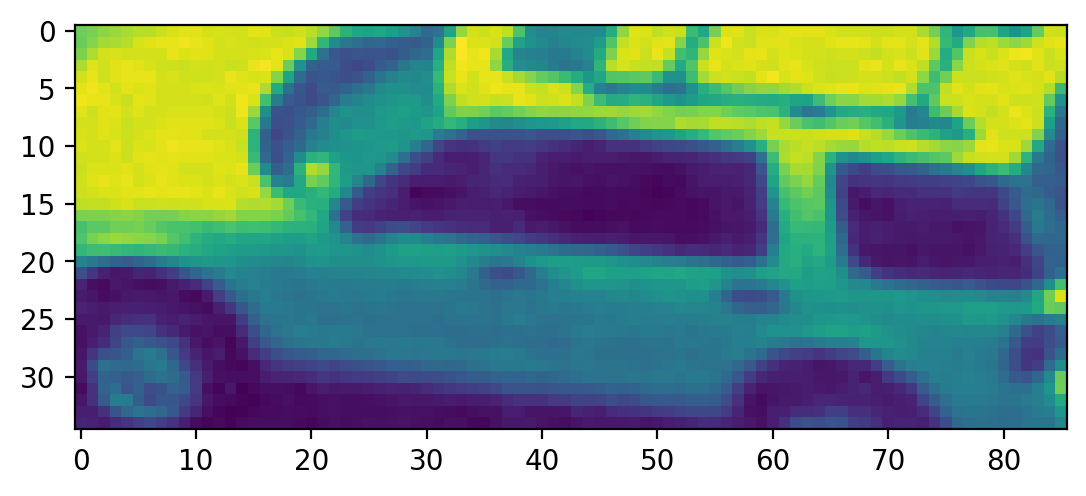

In [195]:
plt.imshow(T)
plt.show()

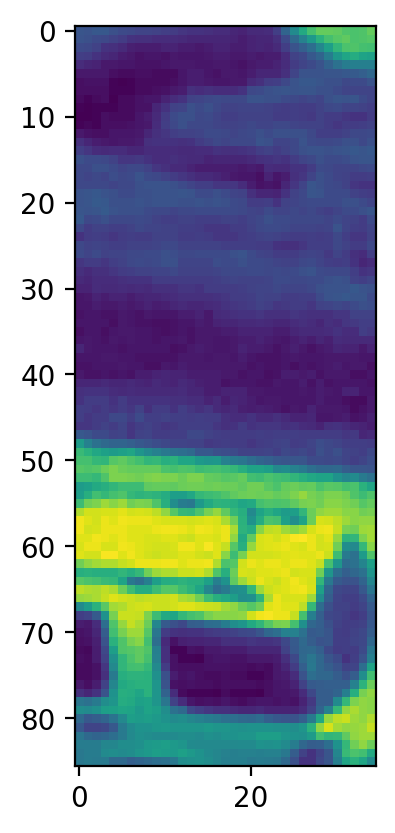

In [189]:
plt.imshow(It[rect[0]:rect[2], rect[1]:rect[3]])

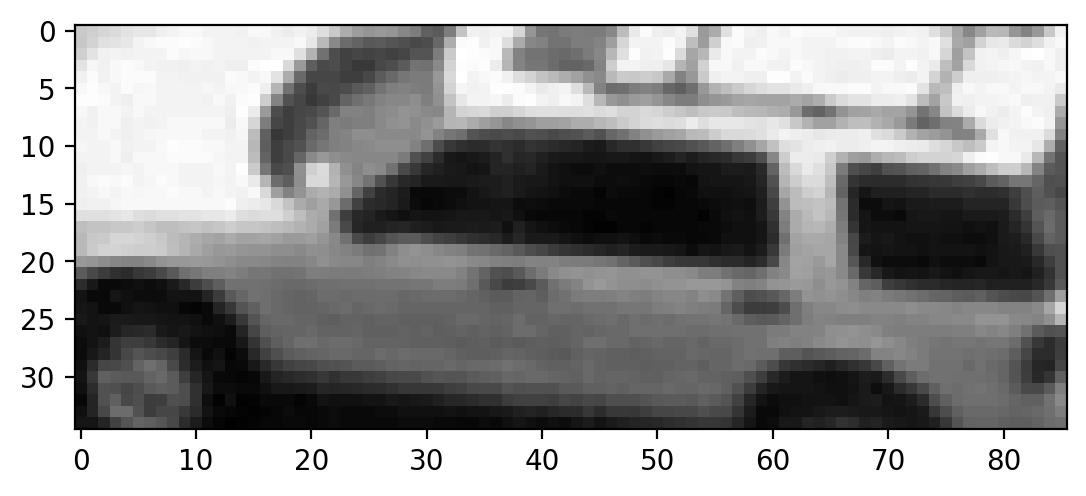

In [155]:
plt.imshow(It[rect[1]:rect[3], rect[0]:rect[2]], cmap='gray')
# plt.show()

In [261]:
def LucasKanade_difftemp(It, It1, rect_temp, rect_cur, threshold, num_iters, p0=np.zeros(2)):
    """
    :param It: template image
    :param It1: Current image
    :param rect_cur: Current position of the car (top left, bot right coordinates)
    :param rect_temp: Template rec position in the template image (top left, bot right coordinates)
    :param threshold: if the length of dp is smaller than the threshold, terminate the optimization
    :param num_iters: number of iterations of the optimization
    :param p0: Initial movement vector [dp_x0, dp_y0]
    :return: p: movement vector [dp_x, dp_y]
    """
	
    # Put your implementation here
    # set up the threshold
    ################### TODO Implement Lucas Kanade ###################
    H_It, W_It = It.shape
    H_It1, W_It1 = It1.shape
    
    x1, y1, x2, y2 = rect[0], rect[1], rect[2], rect[3] #writen in image coordinates, not matrix
    xt1, yt1, xt2, yt2 = rect_temp[0], rect_temp[1], rect_temp[2], rect_temp[3] #writen in image coordinates, not matrix

    H_rect, W_rect = y2 - y1, x2 - x1
    H_rect_temp, W_rect_temp = yt2 - yt1, xt2 - xt1

    It1_y, It1_x = np.gradient(It1) #Gradient of current img

#     x_axis_rect = np.linspace(x1, x2, int(W_rect))
#     y_axis_rect = np.linspace(y1, y2, int(H_rect))
#     X_grid_rect, Y_grid_rect = np.meshgrid(x_axis_rect, y_axis_rect)
    
    x_axis_rect_temp = np.linspace(xt1, xt2, int(round(W_rect_temp)))
    y_axis_rect_temp = np.linspace(yt1, yt2, int(round(H_rect_temp)))
    X_grid_rect_temp, Y_grid_rect_temp = np.meshgrid(x_axis_rect_temp, y_axis_rect_temp)
    

    xt = np.arange(0, W_It, 1)
    yt = np.arange(0, H_It, 1)
    x = np.arange(0, W_It1, 1)
    y = np.arange(0, H_It1, 1)
    spline_It = RectBivariateSpline(yt, xt, It) #Spline interpolation over a rectangular mesh
    spline_It1 = RectBivariateSpline(y, x, It1)
    spline_It1_x = RectBivariateSpline(y, x, It1_x)
    spline_It1_y = RectBivariateSpline(y, x, It1_y)
    
    template_rect = spline_It.ev(Y_grid_rect_temp, X_grid_rect_temp) #Bring template_rect from It

    # Iterations for finding optimal dp
    p = p0
    dp = [[1000], [1000]] #Big dp for while loop
    counter = 1
    while np.square(dp).sum() > threshold and counter <= num_iters:

        # translate the rectangle
        x1_tr, y1_tr, x2_tr, y2_tr = x1+p[0], y1+p[1], x2+p[0], y2+p[1]

        x_axis_rect_tr = np.linspace(x1_tr, x2_tr, int(round(W_rect)))
        y_axis_rect_tr = np.linspace(y1_tr, y2_tr, int(round(H_rect)))
        X_grid_rect_tr, Y_grid_rect_tr = np.meshgrid(x_axis_rect_tr, y_axis_rect_tr)

        spline_It1_tr = spline_It1.ev(Y_grid_rect_tr, X_grid_rect_tr)

        #A, b
        It1_rect_tr_x = spline_It1_x.ev(Y_grid_rect_tr, X_grid_rect_tr)
        It1_rect_tr_y = spline_It1_y.ev(Y_grid_rect_tr, X_grid_rect_tr)
        A = np.vstack((It1_rect_tr_x.ravel(),It1_rect_tr_y.ravel())).T

        b = (template_rect - spline_It1_tr).reshape(-1, 1)
        b = b.reshape(-1,1) #Columnize

        #Solve argmin|Ax-b|^2 for finding dp
        dp = np.linalg.inv(A.T@A) @ (A.T) @ b

        #update parameters
        p[0] += dp[0,0]
        p[1] += dp[1,0]

        counter += 1
        
    return p

In [249]:
int(round(2.9))

3

In [262]:
#Only with the first template
rect = np.array([59, 116, 145, 151]).T

lk_res = []
lk_res.append(rect)
rect_temp = rect
It0 = seq[:,:,0]
It = It0
for i in tqdm(range(1, seq.shape[2])):
    pt_topleft = rect[:2]
    pt_bottomright = rect[2:4]
#     It = seq[:,:,i-1]
    It1 = seq[:,:,i]
    p = LucasKanade_difftemp(It, It1, rect_temp, rect, threshold, num_iters)
    rect = np.concatenate((pt_topleft + p, pt_bottomright + p))
    lk_res.append(rect)

lk_res = np.array(lk_res)
np.save("carseqrects_test.npy", lk_res)


100%|█████████████████████████████████████████| 414/414 [00:08<00:00, 47.27it/s]


In [223]:
template_rect.shape

(4,)

In [253]:
2**3

8

In [263]:
seq = np.load("../data/carseq.npy")

rect_0 = np.array([59, 116, 145, 151]).T
rect = np.copy(rect_0)

threshold_drift = 3
####### Run LK Template correction #######
lk_res = []
lk_res.append(rect)
It0 = seq[:,:,0]
template_idx = 0
rect_temp = rect
It = It0
for i in tqdm(range(1, seq.shape[2])):

    ########## TODO Implement LK with drift correction ##########

    pt_topleft = rect[:2]
    pt_bottomright = rect[2:4]
#     It = seq[:,:,i-1]
    It1 = seq[:,:,i]
    p_n = LucasKanade_difftemp(It, It1, rect_temp, rect, threshold, num_iters)
    rect = np.concatenate((pt_topleft + p_n, pt_bottomright + p_n))
    p_star = LucasKanade_difftemp(It0, It1, rect_0, rect, threshold, num_iters)
    rect = np.concatenate((pt_topleft + p_star, pt_bottomright + p_star))
    
    if np.square(p_star - p_n).sum() <  threshold_drift**2:
        rect_temp = rect
        It = It1
            
#     rect = np.concatenate((pt_topleft + p, pt_bottomright + p))

    lk_res.append(rect)

lk_res = np.array(lk_res)
np.save("carseqrects-wcrt.npy", lk_res)

100%|█████████████████████████████████████████| 414/414 [00:16<00:00, 25.54it/s]


In [215]:
def LucasKanadeAffine(It, It1, threshold, num_iters, p0=np.zeros(6)):
    """
    :param It: template image
    :param It1: Current image
    :param rect: Current position of the car (top left, bot right coordinates) -> template
    :param threshold: if the length of dp is smaller than the threshold, terminate the optimization
    :param num_iters: number of iterations of the optimization
    :param p0: Initial movement vector [dp_x0, dp_y0]
    :return: p: movement vector [dp_x, dp_y]
    """
	
    # Put your implementation here
    # set up the threshold
    ################### TODO Implement Lucas Kanade ###################
    H_It, W_It = It.shape
    
    x1, y1, x2, y2 = rect[0], rect[1], rect[2], rect[3] #writen in image coordinates, not matrix
    H_rect, W_rect = y2 - y1, x2 - x1 

    It1_y, It1_x = np.gradient(It1) #Gradient of current img

    x_axis_rect = np.linspace(x1, x2, int(W_rect))
    y_axis_rect = np.linspace(y1, y2, int(H_rect))
    X_grid_rect, Y_grid_rect = np.meshgrid(x_axis_rect, y_axis_rect)
    
    x = np.arange(0, W_It, 1)
    y = np.arange(0, H_It, 1)   
    spline_It = RectBivariateSpline(y, x, It) #Spline interpolation over a rectangular mesh
    spline_It1 = RectBivariateSpline(y, x, It1)
    spline_It1_x = RectBivariateSpline(y, x, It1_x)
    spline_It1_y = RectBivariateSpline(y, x, It1_y)
    template_rect = spline_It.ev(Y_grid_rect, X_grid_rect) #Bring template_rect from It

    # Iterations for finding optimal dp
    p = p0
    dp = [[1000], [1000]] #Big dp for while loop
    counter = 1
    while np.square(dp).sum() > threshold and counter <= num_iters:

        # translate the rectangle
        x1_tr, y1_tr, x2_tr, y2_tr = x1+p[0], y1+p[1], x2+p[0], y2+p[1]

        x_axis_rect_tr = np.linspace(x1_tr, x2_tr, int(W_rect))
        y_axis_rect_tr = np.linspace(y1_tr, y2_tr, int(H_rect))
        X_grid_rect_tr, Y_grid_rect_tr = np.meshgrid(x_axis_rect_tr, y_axis_rect_tr)

        spline_It1_tr = spline_It1.ev(Y_grid_rect_tr, X_grid_rect_tr)

        #A, b
        It1_rect_tr_x = spline_It1_x.ev(Y_grid_rect_tr, X_grid_rect_tr)
        It1_rect_tr_y = spline_It1_y.ev(Y_grid_rect_tr, X_grid_rect_tr)
        A = np.vstack((It1_rect_tr_x.ravel(),It1_rect_tr_y.ravel())).T

        b = (template_rect - spline_It1_tr).reshape(-1, 1)
        b = b.reshape(-1,1) #Columnize

        #Solve argmin|Ax-b|^2 for finding dp
        dp = np.linalg.inv(A.T@A) @ (A.T) @ b

        #update parameters
        p[0] += dp[0,0]
        p[1] += dp[1,0]

        counter += 1
        
    return p

In [310]:
M = np.array([[1, 0, 0 ], [0, 1, 0]])

In [348]:
cor_leftop = np.array([[1, 2, 2]])
cor_leftop

array([[1, 2, 2]])

In [325]:
cor_leftop[0,1]

2

In [313]:
a = M@cor_leftop.T
a

array([[1],
       [2]])

In [314]:
affine_transform(cor_leftop, M)

array([[1, 2, 2]])

In [326]:
cor_leftop_wp = M@cor_leftop.T

In [332]:
cor_leftop_wp[1,0]

2

In [390]:
def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It: template image
    :param It1: Current image
    :param threshold: if the length of dp is smaller than the threshold, terminate the optimization
    :param num_iters: number of iterations of the optimization
    :return: M: the Affine warp matrix [2x3 numpy array] put your implementation here
    """

    # put your implementation here
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    ################### TODO Implement Lucas Kanade Affine ###################
    H_It, W_It = It.shape
    
    cor_leftop = np.array([[0, 0, 1]])
    cor_rightbot = np.array([[H_It, W_It, 1]])

    It1_y, It1_x = np.gradient(It1) #Gradient of current img

    x = np.arange(0, W_It, 1)
    y = np.arange(0, H_It, 1)   
    spline_It = RectBivariateSpline(y, x, It) #Spline interpolation over a rectangular mesh
    spline_It1 = RectBivariateSpline(y, x, It1)
    spline_It1_x = RectBivariateSpline(y, x, It1_x)
    spline_It1_y = RectBivariateSpline(y, x, It1_y)
    
    x_axis = np.linspace(cor_leftop[0,0], cor_rightbot[0,0], int(round(W_It)))
    y_axis = np.linspace(cor_leftop[0,1], cor_rightbot[0,1], int(round(H_It)))
    X_grid, Y_grid = np.meshgrid(x_axis, y_axis)
    template = spline_It.ev(Y_grid, X_grid)
    It1_splined = spline_It1.ev(Y_grid, X_grid)

    # Iterations for finding optimal dp
    dp = [[1000], [1000]] #Big dp for while loop
    counter = 1
    while np.square(dp).sum() > threshold and counter <= num_iters:
        # Warp Current Image
        cor_leftop_wp = M@cor_leftop.T
        cor_rightbot_wp = M@cor_rightbot.T
        
        x_axis_wp = np.linspace(cor_leftop_wp[0,0], cor_rightbot_wp[0,0], int(round(W_It)))
        y_axis_wp = np.linspace(cor_leftop_wp[1,0], cor_rightbot_wp[1,0], int(round(H_It)))
        X_grid_wp, Y_grid_wp = np.meshgrid(x_axis_wp, y_axis_wp)
        It1_wp = spline_It1.ev(Y_grid_wp, X_grid_wp)
        
        #Get A and b
        It1_wp_x = spline_It1_x.ev(Y_grid_wp, X_grid_wp)
        It1_wp_y = spline_It1_y.ev(Y_grid_wp, X_grid_wp)
        Del_It1_wp = np.vstack((It1_wp_x.ravel(),It1_wp_y.ravel())).T
        
        A = np.zeros((H_It*W_It, 6))
        
        for i in range(H_It):
            for j in range(W_It):
                #I is (1,2) for each pixel
                #Jacobiani is (2,6)for each pixel
                Del_It1_wp_point = np.array([Del_It1_wp[i*W_It+j]]).reshape(1,2)
                jacob_point = np.array([[j, i, 1, 0, 0, 0], [0, 0, 0, j, i, 1]])
                A[i*W_It+j] = Del_It1_wp_point @ jacob_point
        
        b = (template - It1_wp).reshape(-1,1)

        #Solve argmin|Ax-b|^2 for finding dp
        dp = np.linalg.inv(A.T@A) @ (A.T) @ b

        #Updating
        M[0,0] += dp[0,0]
        M[0,1] += dp[1,0]
        M[0,2] += dp[2,0]
        M[1,0] += dp[3,0]
        M[1,1] += dp[4,0]
        M[1,2] += dp[5,0]

        counter += 1
    
    return M

In [410]:
def SubtractDominantMotion(image1, image2, threshold, num_iters, tolerance):
    """
    :param image1: Images at time t
    :param image2: Images at time t+1
    :param threshold: used for LucasKanadeAffine
    :param num_iters: used for LucasKanadeAffine
    :param tolerance: binary threshold of intensity difference when computing the mask
    :return: mask: [nxm]
    """
    
    # put your implementation here
    mask = np.ones(image1.shape, dtype=bool)

    ################### TODO Implement Substract Dominent Motion ###################
    M = LucasKanadeAffine(image1, image2, threshold, num_iters)
    image2_wp = affine_transform(image2, M, output_shape = image1.shape)
        
#    UNCOMMENT THE FOLLOWING IF YOU WANT TO USE INVERSE COMPOSITION
#    M = InverseCompositionAffine(image1, image2)
#    image2_w = cv2.warpAffine(image2, M[:2, :], image1.T.shape)

    image2_wp = binary_dilation(binary_erosion(image2_wp))
    abs_diff = np.abs(image1 - image2_wp)
    mask = (abs_diff > tolerance)

    return mask.astype(bool)

In [438]:
num_iters = 1e3
threshold = 1e-2
tolerance = 0.8
seq = np.load('../data/antseq.npy')
plot_idx = [30,60,90,120]

#### Running LK + Motion detection
masks = []
for i in tqdm(range(1, seq.shape[2])):# 
# for i in range(1, 5):
    It = seq[:,:,i-1]
    It1 = seq[:,:,i]
    
    mask = SubtractDominantMotion(It, It1, threshold = threshold, num_iters = num_iters, tolerance = tolerance)
    masks.append(mask)
#     plt.imshow(mask)
#     plt.show()
    
masks = np.stack(masks, axis=2)
np.save("ant_masks.npy", masks)

 13%|█████▍                                    | 16/124 [00:11<01:20,  1.35it/s]


KeyboardInterrupt: 

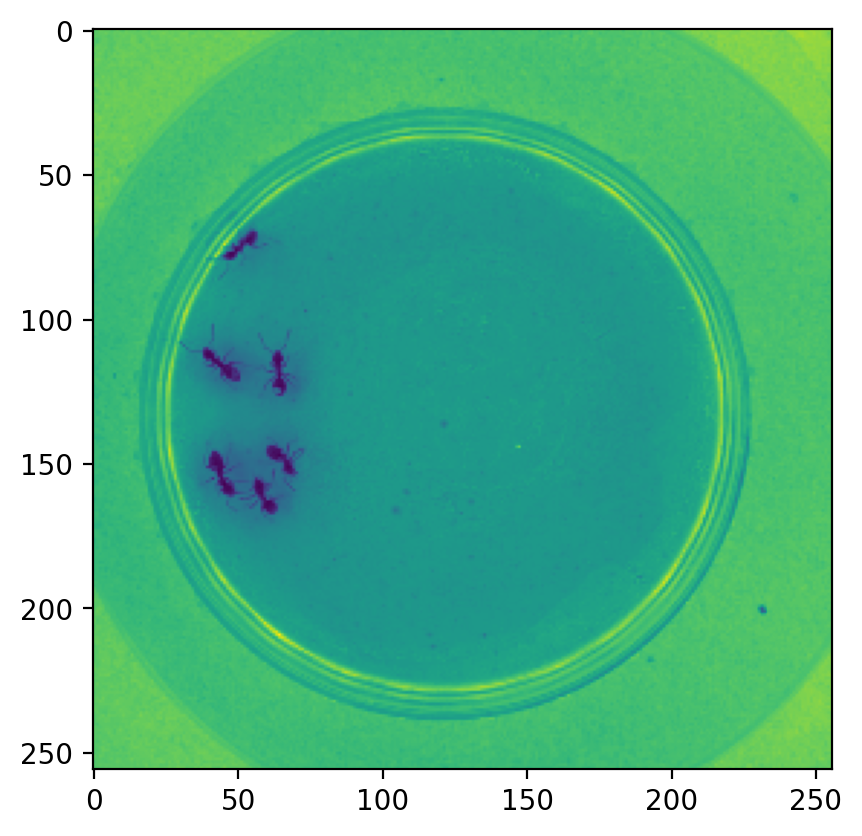

In [365]:
plt.imshow(seq[:,:,10])

In [397]:
seq = np.load('../data/aerialseq.npy')
plot_idx = [30,60,90,120]

#### Running LK + Motion detection
masks = []
for i in tqdm(range(1, seq.shape[2])):# for i in range(1, 5):
    print(i)
    It = seq[:,:,i-1]
    It1 = seq[:,:,i]
    
    mask = SubtractDominantMotion(It, It1, threshold = threshold, num_iters = num_iters, tolerance = tolerance)
    masks.append(mask)
    # plt.imshow(mask)
    # plt.show()
    
masks = np.stack(masks, axis=2)
np.save("aerial_masks.npy", masks)


  0%|                                                   | 0/149 [00:00<?, ?it/s]

1


  0%|                                                   | 0/149 [00:01<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (240,320) (320,240) 

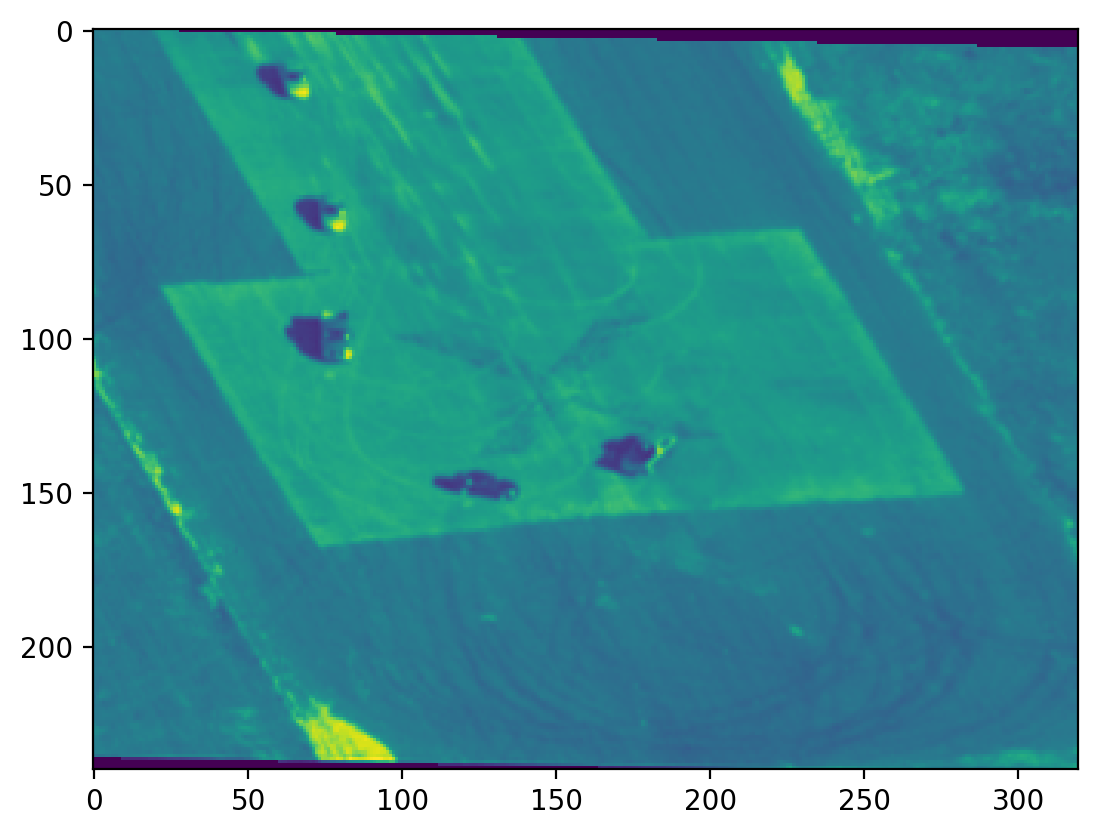

In [412]:
image1 = seq[:,:,i-1]
image2= seq[:,:,i]

mask = np.ones(image1.shape, dtype=bool)

################### TODO Implement Substract Dominent Motion ###################
M = LucasKanadeAffine(image1, image2, threshold, num_iters)
image2_wp = affine_transform(image2, M, output_shape = image1.shape)
# image2_wp = cv2.warpAffine(image2, M, image1.T.shape)
plt.imshow(image2_wp)

#    UNCOMMENT THE FOLLOWING IF YOU WANT TO USE INVERSE COMPOSITION
#    M = InverseCompositionAffine(image1, image2)
#    image2_w = cv2.warpAffine(image2, M[:2, :], image1.T.shape)

# image2_wp = binary_dilation(binary_erosion(image2_wp))
# abs_diff = np.abs(image1 - image2_wp)
# mask = (abs_diff > tolerance)


In [413]:
image2_wp[0,300]

0.0

In [408]:
image2_wp.shape

(320, 240)

In [425]:
M0 = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
np.vstack((M0, [0, 0, 1]))

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [22]:
def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param It: template image
    :param It1: Current image
    :param threshold: if the length of dp is smaller than the threshold, terminate the optimization
    :param num_iters: number of iterations of the optimization
    :return: M: the Affine warp matrix [2x3 numpy array]
    """

    # put your implementation here
    M0 = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    ################### TODO Implement Inverse Composition Affine ###################
    H_It, W_It = It.shape
    
    cor_leftop = np.array([[0, 0, 1]])
    cor_rightbot = np.array([[H_It, W_It, 1]])

    x = np.arange(0, W_It, 1)
    y = np.arange(0, H_It, 1)   
    spline_It = RectBivariateSpline(y, x, It) #Spline interpolation over a rectangular mesh
    spline_It1 = RectBivariateSpline(y, x, It1)

    x_axis = np.linspace(cor_leftop[0,0], cor_rightbot[0,0], int(round(W_It)))
    y_axis = np.linspace(cor_leftop[0,1], cor_rightbot[0,1], int(round(H_It)))
    X_grid, Y_grid = np.meshgrid(x_axis, y_axis)
    template = spline_It.ev(Y_grid, X_grid)

    It_y, It_x = np.gradient(It) #Gradient of template img
    Del_It = np.vstack((It_x.ravel(),It_y.ravel())).T

    M = M0
    M_sq = np.vstack((M, [0, 0, 1]))
    
    #Precompute A here
    A = np.zeros((H_It*W_It, 6))        
    for i in range(H_It):
        for j in range(W_It):
            #I is (1,2) for each pixel
            #Jacobiani is (2,6)for each pixel
            Del_It_point = np.array([Del_It[i*W_It+j]]).reshape(1,2)
            jacob_point = np.array([[j, i, 1, 0, 0, 0], [0, 0, 0, j, i, 1]])
            A[i*W_It+j] = Del_It_point @ jacob_point
    
    H = np.linalg.inv(A.T@A)
    Precomp = H @ A.T
    # Iterations for finding optimal dp
    dp = [[1000], [1000]] #Big dp for while loop
    counter = 1
    while np.square(dp).sum() > threshold and counter <= num_iters:
        
        # Warp Current Image
        cor_leftop_wp = M@cor_leftop.T
        cor_rightbot_wp = M@cor_rightbot.T
        
        x_axis_wp = np.linspace(cor_leftop_wp[0,0], cor_rightbot_wp[0,0], int(round(W_It)))
        y_axis_wp = np.linspace(cor_leftop_wp[1,0], cor_rightbot_wp[1,0], int(round(H_It)))
        X_grid_wp, Y_grid_wp = np.meshgrid(x_axis_wp, y_axis_wp)
        It1_wp = spline_It1.ev(Y_grid_wp, X_grid_wp)
        
        #Get b
        b = (It1_wp - template).reshape(-1,1)

        #Solve argmin|Ax-b|^2 for finding dp
        dp = Precomp @ b
        
        #Updating
        dM = np.array([[1+dp[0,0], dp[1,0], dp[2,0]], [dp[3,0], 1+dp[4,0], dp[5,0]], [0, 0, 1]])  #dM should be square to be inversed
#         M_sq = np.vstack((M, [0, 0, 1]))
        M_sq = M_sq @ np.linalg.inv(dM)
        M = M_sq[:2, :]
        counter += 1
        
    return M


In [23]:
def SubtractDominantMotion_InvComp(image1, image2, threshold, num_iters, tolerance):
    """
    :param image1: Images at time t
    :param image2: Images at time t+1
    :param threshold: used for LucasKanadeAffine
    :param num_iters: used for LucasKanadeAffine
    :param tolerance: binary threshold of intensity difference when computing the mask
    :return: mask: [nxm]
    """
    
    # put your implementation here
    mask = np.ones(image1.shape, dtype=bool)

    ################### TODO Implement Substract Dominent Motion ###################
    M = InverseCompositionAffine(image1, image2, threshold, num_iters)
    image2_wp = affine_transform(image2, M, output_shape = image1.shape)
    
    image2_wp = binary_dilation(binary_erosion(image2_wp))
    abs_diff = np.abs(image1 - image2_wp)
    mask = (abs_diff > tolerance)

    return mask.astype(bool)

In [453]:
num_iters = 1e3
threshold = 1e-2
tolerance = 0.8
seq = np.load('../data/antseq.npy')
plot_idx = [30,60,90,120]

#### Running LK + Motion detection
masks = []
for i in tqdm(range(1, seq.shape[2])):# 
# for i in range(1, 7):
    It = seq[:,:,i-1]
    It1 = seq[:,:,i]
    
    mask = SubtractDominantMotion_InvComp(It, It1, threshold = threshold, num_iters = num_iters, tolerance = tolerance)
    masks.append(mask)
    
#     plt.imshow(mask)
#     plt.show()
    
masks = np.stack(masks, axis=2)
np.save("ant_masks_invcomp.npy", masks)

100%|█████████████████████████████████████████| 124/124 [00:48<00:00,  2.56it/s]


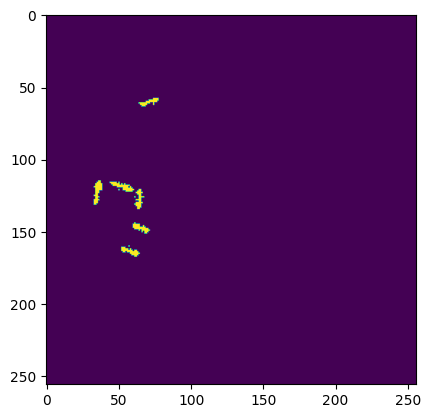

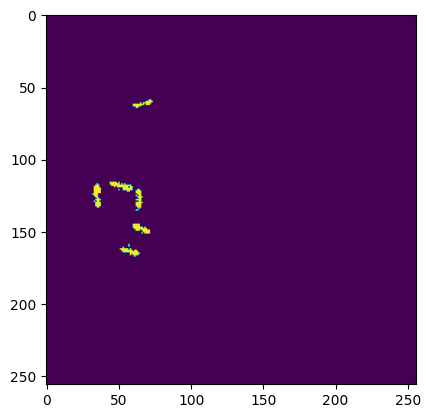

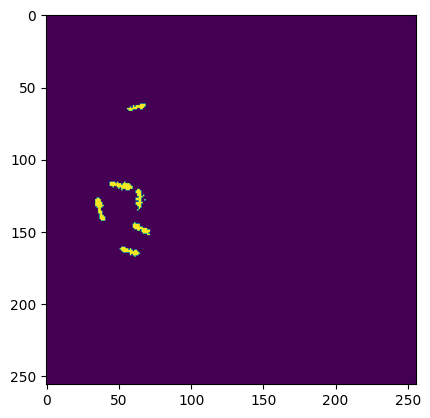

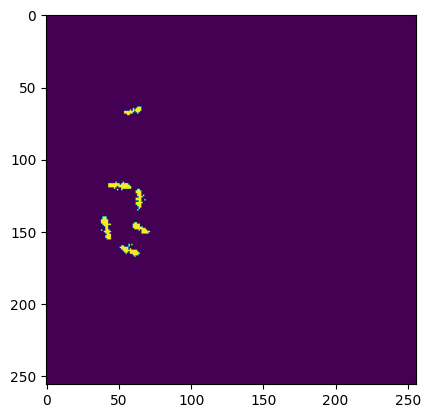

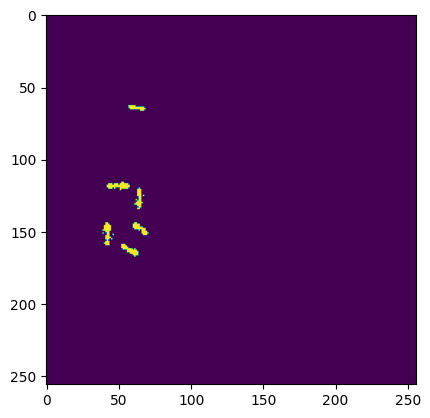

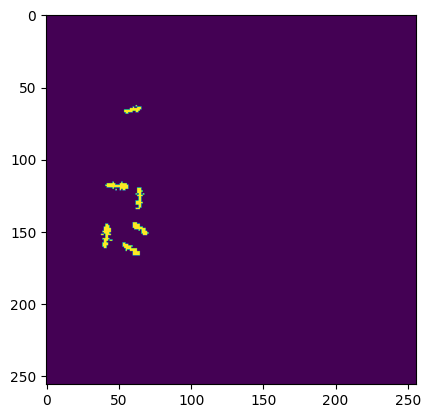

In [37]:
num_iters = 1e3
threshold = 1e-2
tolerance = 0.8
seq = np.load('../data/antseq.npy')
plot_idx = [30,60,90,120]

#### Running LK + Motion detection
masks = []
# for i in tqdm(range(1, seq.shape[2])):# 
for i in range(1, 7):
    It = seq[:,:,i-1]
    It1 = seq[:,:,i]
    
    mask = SubtractDominantMotion_InvComp(It, It1, threshold = threshold, num_iters = num_iters, tolerance = tolerance)
    masks.append(mask)
    
    plt.imshow(mask)
    plt.show()
    
masks = np.stack(masks, axis=2)
# np.save("ant_masks_invcomp.npy", masks)

In [38]:
seq[:, :, 0]

array([[0.66470588, 0.66666667, 0.67941176, ..., 0.72647059, 0.71372549,
        0.70882353],
       [0.67254902, 0.66862745, 0.68137255, ..., 0.73529412, 0.70686275,
        0.7254902 ],
       [0.66862745, 0.67254902, 0.66568627, ..., 0.73333333, 0.71176471,
        0.7254902 ],
       ...,
       [0.65      , 0.65588235, 0.66078431, ..., 0.68431373, 0.67647059,
        0.67352941],
       [0.65196078, 0.65980392, 0.66666667, ..., 0.68333333, 0.68039216,
        0.67843137],
       [0.64705882, 0.65098039, 0.65882353, ..., 0.67156863, 0.68431373,
        0.68627451]])

In [120]:
cap = cv2.VideoCapture('../data/Clean.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameHeight, frameWidth, int(frameCount/2)), np.dtype('uint8'))

fc = 0
ret = True
i = 0

while (fc < frameCount  and ret):
    if (fc%2 == 0):
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        buf[:, :, i] = frame
        i += 1

#     buf[:, :, fc] = np.array(frame).astype(np.float32)/255

    fc += 1

cap.release()

buf = np.array(buf).astype(np.float32)/255


# cv2.namedWindow('frame 10')
# cv2.imshow('frame 10', buf[9])

# cv2.waitKey(0)

In [121]:
buf[:,:,0]

array([[0.5019608 , 0.5019608 , 0.5019608 , ..., 0.4392157 , 0.43529412,
        0.43137255],
       [0.5019608 , 0.5019608 , 0.5019608 , ..., 0.4392157 , 0.43529412,
        0.43529412],
       [0.5019608 , 0.5019608 , 0.5019608 , ..., 0.43529412, 0.43529412,
        0.43137255],
       ...,
       [0.68235296, 0.6784314 , 0.6784314 , ..., 0.56078434, 0.56078434,
        0.5568628 ],
       [0.6784314 , 0.6784314 , 0.6745098 , ..., 0.5647059 , 0.5529412 ,
        0.54509807],
       [0.6784314 , 0.6784314 , 0.6745098 , ..., 0.5647059 , 0.5411765 ,
        0.5411765 ]], dtype=float32)

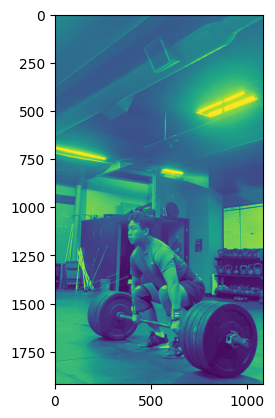

In [115]:
plt.imshow(buf[:,:,2])

In [122]:
cap = cv2.VideoCapture('../data/Clean.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameHeight, frameWidth, int(frameCount/2)), np.dtype('float32'))

fc = 0
ret = True
i = 0

while (fc < frameCount  and ret):
    if (fc%2 == 0):
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        frame_min = frame.min(axis=(0, 1), keepdims=True)
        frame_max = frame.max(axis=(0, 1), keepdims=True)
        frame = (frame - frame_min) / (frame_max - frame_min)
        buf[:, :, i] = frame
        i += 1
    fc += 1

cap.release()
np.save('../data/squatclean_norm.npy', buf)

In [123]:
buf[:,:,0]

array([[0.5019608 , 0.5019608 , 0.5019608 , ..., 0.4392157 , 0.43529412,
        0.43137255],
       [0.5019608 , 0.5019608 , 0.5019608 , ..., 0.4392157 , 0.43529412,
        0.43529412],
       [0.5019608 , 0.5019608 , 0.5019608 , ..., 0.43529412, 0.43529412,
        0.43137255],
       ...,
       [0.68235296, 0.6784314 , 0.6784314 , ..., 0.56078434, 0.56078434,
        0.5568628 ],
       [0.6784314 , 0.6784314 , 0.6745098 , ..., 0.5647059 , 0.5529412 ,
        0.54509807],
       [0.6784314 , 0.6784314 , 0.6745098 , ..., 0.5647059 , 0.5411765 ,
        0.5411765 ]], dtype=float32)

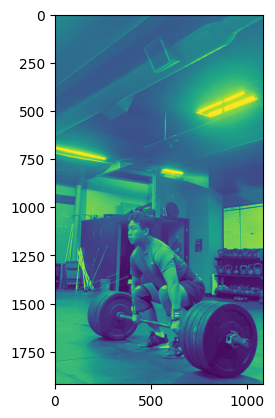

In [124]:
plt.imshow(buf[:,:,2])

In [125]:
np.save('../data/squatclean_norm.npy', buf)

In [126]:
seq.shape

(1920, 1080, 141)

In [131]:
num_iters = 1e3
threshold = 1e-2
tolerance = 0.8
seq = np.load('../data/squatclean_norm.npy')
plot_idx = [30,60,90,120]

#### Running LK + Motion detection
masks = []
for i in tqdm(range(1, seq.shape[2])):# 
# for i in range(110, 114):
    It = seq[:,:,i-1]
    It1 = seq[:,:,i]
    
    mask = SubtractDominantMotion_InvComp(It, It1, threshold = threshold, num_iters = num_iters, tolerance = tolerance)
    masks.append(mask)
    
    
masks = np.stack(masks, axis=2)
np.save("squatclean_masks_invcomp.npy", masks)

100%|█████████████████████████████████████████| 140/140 [34:49<00:00, 14.92s/it]


In [88]:
masks[:,:,1]

array([[False,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True, False, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True, False]])

In [81]:
masks.shape

(1920, 1080, 140)

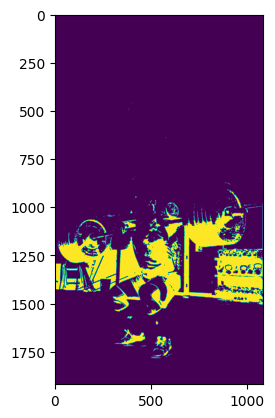

In [80]:
plt.imshow(masks[:,:,100])